<a href="https://colab.research.google.com/github/Devashish-dixit/Mexico-Apartments-Price-Prediction/blob/main/MexicoApartmentPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders

Imporitng required libraries

In [8]:
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

## Preparing Data

### Import

The Wrangle function performs the following tasks:

1. Subset the data in the CSV file and return only apartments in Mexico City that cost less than $100,000.
2. Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".
3. Create separate "lat" and "lon" columns.
4. Mexico City is divided into 15 boroughs, Creating a "borough" feature from the "place_with_parent_names" column.
5. Drop columns that are more than 50% null values.
6. Drop columns containing low- or high-cardinality categorical values.
7. Drop any columns that would constitute leakage for the target "price_aprox_usd".
8. Drop any columns that would create issues of multicollinearity.






In [9]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_df = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_df & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)

    #drop features with high null count
    df.drop(columns=['floor','rooms','expenses','price_usd_per_m2'],inplace=True)

    #drop too low/high cardinality categorical columns
    df.drop(columns=['operation','property_type','currency','properati_url'],inplace=True)

    #drop leaky features
    df.drop(columns=['price',
 'price_aprox_local_currency',
 'price_per_m2'],inplace=True)

    #drop features causing multicolinearity
    df.drop(columns=['surface_total_in_m2'],inplace=True)

    return df

Accessing files with similar names using glob

In [10]:
testdf = pd.read_csv('/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-1.csv')
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4628 non-null   object 
 1   property_type               4628 non-null   object 
 2   place_with_parent_names     4628 non-null   object 
 3   lat-lon                     4144 non-null   object 
 4   price                       4538 non-null   float64
 5   currency                    4538 non-null   object 
 6   price_aprox_local_currency  4538 non-null   float64
 7   price_aprox_usd             4538 non-null   float64
 8   surface_total_in_m2         1668 non-null   float64
 9   surface_covered_in_m2       4436 non-null   float64
 10  price_usd_per_m2            1150 non-null   float64
 11  price_per_m2                4249 non-null   float64
 12  floor                       291 non-null    float64
 13  rooms                       136 n

Using this information, we identify columns that are more than 50% null values

In [11]:
files=glob('/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-*.csv')
files

['/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-2.csv',
 '/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-4.csv',
 '/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-5.csv',
 '/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-3.csv',
 '/content/drive/MyDrive/Data/Mexico/mexico-city-real-estate-1.csv']

Using list comprehension with the wrangle function to concatenate all the files into a single dataframe

In [12]:
df = pd.concat([wrangle(file) for file in files],ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,63223.78,88.0,19.516777,-99.160149,Gustavo A. Madero
1,25289.51,48.0,19.466724,-99.131614,Gustavo A. Madero
2,89250.90,90.0,19.383327,-99.152712,Benito Juárez
3,39887.51,60.0,19.388280,-99.195529,Álvaro Obregón
4,42475.37,80.0,19.454582,-99.145651,Cuauhtémoc


## Exploring the Data

Creating a histogram showing the distribution of apartment prices

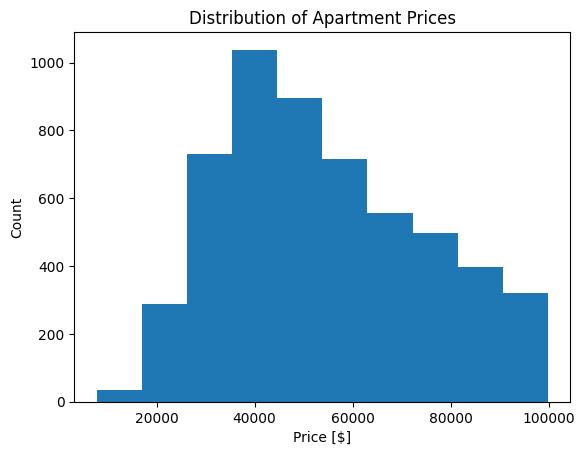

In [13]:
plt.hist(df.price_aprox_usd)
plt.xlabel('Price [$]')
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices");

Creating a scatter plot that shows apartment price as a function of apartment size

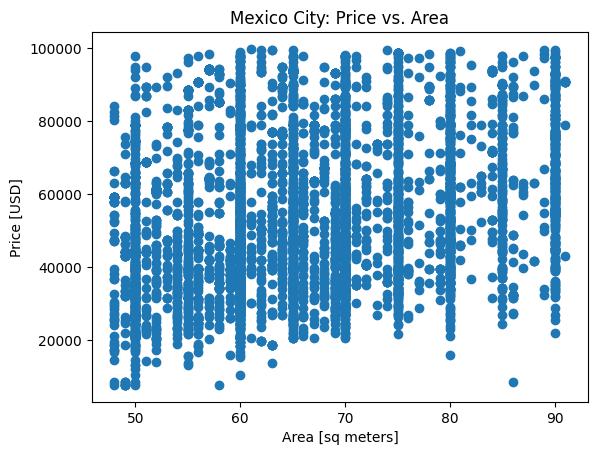

In [14]:
plt.scatter(x=df.surface_covered_in_m2,y=df.price_aprox_usd)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

Creating a Mapbox scatter plot that shows the location of the apartments in the dataset and represent their price using color

In [15]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")


fig.show(renderer="colab")

## Splitting the dataset


We split our dataframe into the feature matrix and target vector

In [16]:
target = "price_aprox_usd"
features=['surface_covered_in_m2','lat','lon',"borough"]
X_train=df[features]
y_train=df[target]

## Building The Model

Calculating the baseline mean absolute error for the model.

In [17]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


Our progressive model must beat the baseline mean absolute error to be prove its significance

Creating a pipeline that contains OneHotEncoder and SimpleImputer  as the transformers and Ridge Regression as the model to implement regularization

In [18]:
# Build Model
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)

# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Obtaining the model's mean absolute error score

In [19]:
y_pred = model.predict(X_train)
mean_absolute_error(y_train,y_pred)

14943.16582406391

Our model's mean absolute error beats baseline score which proves that our model has a statistical significance

## Generating Prediction for additional data not used in training

Read the CSV file mexico-city-test-features.csv into the DataFrame
X_test

In [20]:
X_test = pd.read_csv('/content/drive/MyDrive/Data/Mexico/mexico-city-test-features.csv')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


Using our model, we generate a Series of predictions for X_test

In [21]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

## Communication of results

* Firstly, we create a Series named feat_imp. The index contains the names of all the features your model considers when making predictions; the values are the coefficient values associated with each feature. The Series is sorted ascending by absolute value.
* Secondly,we create a horizontal bar chart that shows the 10 most influential coefficients for our model

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



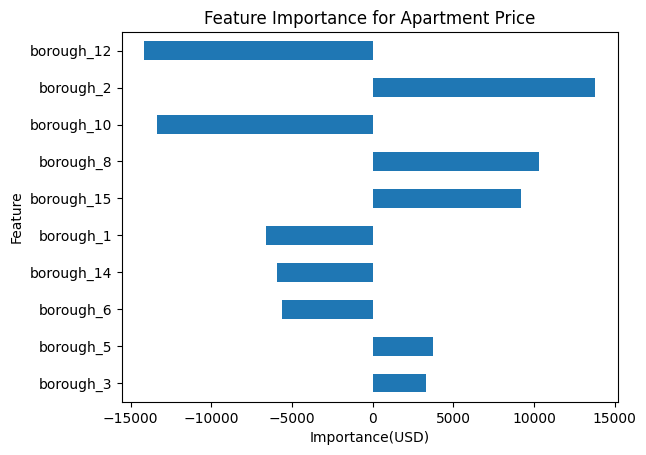

In [22]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients,index=features)
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel('Importance(USD)')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price');

From the visualization, it is safe to make inferences such as houses in borough 2 tend to be more expensive whereas houses in borough 2 tend to have less of a financial value.

*In conclusion, the "MexicoApartmentPricePrediction" notebook has taken us through a comprehensive journey in predicting apartment prices in Mexico. We meticulously prepared the data using the wrangle function and gained insights by visualizing the data through histograms and scatter plots, exploring price distributions and their relationship with apartment sizes and locations. Splitting the data and establishing a baseline MAE set the stage for our predictive model. The pipeline, incorporating OneHotEncoder, SimpleImputer, and Ridge Regression, not only improved accuracy but also introduced regularization. Our model, backed by statistical significance, performed well on test data, and the influential coefficients highlighted in the horizontal bar chart provide actionable insights for informed decision-making in the real estate market.*